In [117]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim

In [56]:
x_domain = np.linspace(0, 10, 250) 
training_values = []
test_values = []
noise_intensity = np.random.uniform(0,1)

In [145]:
def random_phase_generator():
    phi = np.ones(x_domain.shape)
    phi = phi*np.random.uniform(0,180)
    return phi

In [147]:
x_train = np.sin(x_domain + phase) + np.random.normal(size = 250, scale = 0.5*noise_intensity)
x_train = np.reshape(x_train, (1,250))
y_train = np.sin(x_domain + phase)
y_train = np.reshape(y_train, (1,250))
x_test = np.sin(x_domain + phase) + np.random.normal(size = 250, scale = 0.5*noise_intensity)
x_test = np.reshape(x_test, (1,250))
y_test = np.sin(x_domain + phase)
y_test = np.reshape(y_test, (1,250))

In [149]:
training_dataset_hdf5_path = 'hdf5_datasets/training_data.hdf5'
test_dataset_hdf5_path = 'hdf5_datasets/test_data.hdf5'

file_train = h5py.File(training_dataset_hdf5_path, "w")
file_train.create_dataset('training_dataset_noisy', dtype = 'f', data=x_train)
file_train.create_dataset('training_dataset', dtype = 'f', data=y_train)
file_train.close()

file_test = h5py.File(test_dataset_hdf5_path, "w")
file_test.create_dataset('test_dataset_noisy', dtype = 'f', data=x_test)
file_test.create_dataset('test_dataset', dtype = 'f', data=y_test)
file_test.close()


In [171]:
class Encoder(nn.Module):    
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(250, 500)
        self.fc2 = nn.Linear(500, 1000)
        self.activation = nn.Sigmoid()
    
    def forward(self, noised_input):
        h = self.activation(self.fc1(noised_input))
        z = self.fc2(h)
        return z
    

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(1000, 500)
        self.fc2 = nn.Linear(500, 250)
        self.activation = nn.Sigmoid()
    
    def forward(self, Encoded_Map):
        h = self.activation(self.fc1(Encoded_Map))
        output = self.fc2(h)
        return output

In [172]:
encoder = Encoder()
decoder = Decoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(encoder.parameters())
optimizer = optim.Adam(decoder.parameters())

In [173]:
total_epochs = 10
epoch_loss_data = [] 
for epoch in range(total_epochs):
    running_loss = 0
    if running_loss == 0:
        for i in range(750):
            phase = random_phase_generator()
            x_train = np.sin(x_domain + phase) + np.random.normal(size = 250, scale = 0.5*noise_intensity)
            x_train = np.reshape(x_train, (1,250))
            y_train = np.sin(x_domain + phase)
            y_train = np.reshape(y_train, (1,250))
            
            inputs, target = Variable((torch.FloatTensor(x_train)), requires_grad = True), Variable(torch.FloatTensor(y_train))
            
            optimizer.zero_grad()

            output = encoder(inputs)
            output = decoder(output)
            loss = criterion(output, target = target)
            loss.backward()
            optimizer.step()
            running_loss += loss.data[0]
            
            if i%100 == 99:
                print(i + 1, 'done')
    epoch_loss_data.append(running_loss)
    print(epoch + 1,': loss =', running_loss)

100 done
200 done
300 done
400 done
500 done
600 done
700 done
1 : loss = 64.03253181511536
100 done
200 done
300 done
400 done
500 done
600 done
700 done
2 : loss = 4.953969080383104
100 done
200 done
300 done
400 done
500 done
600 done
700 done
3 : loss = 4.779188843524025
100 done
200 done
300 done
400 done
500 done
600 done
700 done
4 : loss = 3.9803998960196623
100 done
200 done
300 done
400 done
500 done
600 done
700 done
5 : loss = 3.997370652083191
100 done
200 done
300 done
400 done
500 done
600 done
700 done
6 : loss = 3.7274437235791993
100 done
200 done
300 done
400 done
500 done
600 done
700 done
7 : loss = 3.879640624360036
100 done
200 done
300 done
400 done
500 done
600 done
700 done
8 : loss = 4.037428433690366
100 done
200 done
300 done
400 done
500 done
600 done
700 done
9 : loss = 3.1943735104323423
100 done
200 done
300 done
400 done
500 done
600 done
700 done
10 : loss = 3.3597988577785145


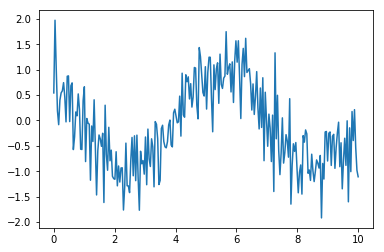

In [174]:
#Lets show the difference between the original noised input and output
x_train = x_train.reshape((250,))
plt.plot(x_domain, x_train)

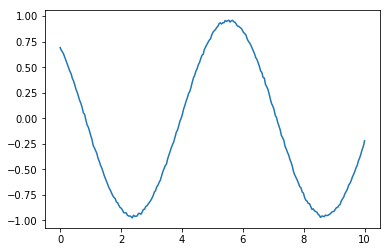

In [175]:
output = output.data[0]
output = np.array(output)
output = np.reshape(output, (250,))
plt.plot(x_domain, output)

In [176]:
running_test_loss = 0.0
for i in range(250):
    phase = random_phase_generator()
    x_test = np.sin(x_domain + phase) + np.random.normal(size = 250, scale = 0.5*noise_intensity)
    x_test = np.reshape(x_test, (1,250))
    y_test = np.sin(x_domain + phase)
    y_test = np.reshape(y_test, (1,250))
    
    input_test, target = Variable(torch.FloatTensor(x_test), requires_grad = True), Variable(torch.FloatTensor(y_test)) 
    
    output_test = encoder(input_test)
    output_test = decoder(output_test)
    loss = criterion(output_test, target)
    running_test_loss = loss.data[0]
print(running_test_loss)

0.006889852229505777


In [156]:
#How to access hdf5 files
#train_file = h5py.File('trainsine.hdf5','r')
#x_train=train_file['dataset_2'][:]
#y_train=train_file['dataset_1'][:]
#train_file.close()

#test_file = h5py.File('testsine.hdf5','r')
#x_test=test_file['dataset_2'][:]
#y_test=test_file['dataset_1'][:]
#test_file.close()